# Week#5
## Композиции алгоритмов
### Размер случайного леса

Случайный лес — это модель классификации, объединяющая некоторое количество решающих деревьев в одну композицию, за счет чего улучшается их качество работы и обобщающая способность. Деревья строятся независимо друг от друга. Чтобы они отличались друг от друга, обучение проводится не на всей обучающей выборке, а на ее случайном подмножестве. Также, для дальнейшего уменьшения схожести деревьев, оптимальный признак для разбиения выбирается не из всех возможных признаков, а лишь из их случайного подмножества. Прогнозы, выданные деревьями, объединяются в один ответ путем усреднения.

Особенность случайного леса заключается в том, что он не переобучается по мере увеличения количества деревьев в композиции. Это достигается за счет того, что деревья не зависят друг от друга, и поэтому добавление нового дерева в композицию не усложняет модель, а лишь понижает уровень шума в прогнозах.

В библиотеке scikit-learn случайные леса реализованы в классах sklearn.ensemble.RandomForestClassifier (для классификации) и sklearn.ensemble.RandomForestRegressor (для регрессии). Обучение модели производится с помощью функции fit, построение прогнозов — с помощью функции predict. Число деревьев задается с помощью поля класса n_estimators.

Пример использования:

import numpy as np

from sklearn.ensemble import RandomForestRegressor

X = np.array([[1, 2], [3, 4], [5, 6]])

y = np.array([-3, 1, 10])

clf = RandomForestRegressor(n_estimators=100)

clf.fit(X, y)

predictions = clf.predict(X)

Также в этом задании вам понадобится вычислять качество предсказаний на тестовой выборке. Мы будем пользоваться метрикой R2 — по сути, это среднеквадратичная ошибка (MSE), нормированная на отрезок [0, 1] и обращенная так, чтобы ее наилучшим значением была единица. Ее можно вычислить с помощью функции sklearn.metrics.r2_score. Первым аргументов является список правильных ответов на выборке, вторым — список предсказанных ответов. Пример использования:

from sklearn.metrics import r2_score

print r2_score([10, 11, 12], [9, 11, 12.1])

В этом задании вам нужно проследить за изменением качества случайного леса в зависимости от количества деревьев в нем.

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer

In [3]:
# Загрузите данные из файла abalone.csv. Это датасет, в котором требуется предсказать 
# возраст ракушки (число колец) по физическим измерениям.
data = pd.read_csv('data/abalone.csv')
data.head(5)

Sex  Length  Diameter  Height  WholeWeight  ShuckedWeight  VisceraWeight  \
0   M   0.455     0.365   0.095       0.5140         0.2245         0.1010   
1   M   0.350     0.265   0.090       0.2255         0.0995         0.0485   
2   F   0.530     0.420   0.135       0.6770         0.2565         0.1415   
3   M   0.440     0.365   0.125       0.5160         0.2155         0.1140   
4   I   0.330     0.255   0.080       0.2050         0.0895         0.0395   

   ShellWeight  Rings  
0        0.150     15  
1        0.070      7  
2        0.210      9  
3        0.155     10  
4        0.055      7

In [4]:
# Преобразуйте признак Sex в числовой: значение F должно перейти в -1, I — в 0, M — в 1. 
# Если вы используете Pandas, то подойдет следующий код: 
#   data['Sex'] = data['Sex'].map(lambda x: 1 if x == 'M' else (-1 if x == 'F' else 0))
data['Sex'] = data['Sex'].map(lambda x : 1 if x == 'M' else (-1 if x == 'F' else 0))
data.head(5)

Sex  Length  Diameter  Height  WholeWeight  ShuckedWeight  VisceraWeight  \
0    1   0.455     0.365   0.095       0.5140         0.2245         0.1010   
1    1   0.350     0.265   0.090       0.2255         0.0995         0.0485   
2   -1   0.530     0.420   0.135       0.6770         0.2565         0.1415   
3    1   0.440     0.365   0.125       0.5160         0.2155         0.1140   
4    0   0.330     0.255   0.080       0.2050         0.0895         0.0395   

   ShellWeight  Rings  
0        0.150     15  
1        0.070      7  
2        0.210      9  
3        0.155     10  
4        0.055      7

In [5]:
# Разделите содержимое файлов на признаки и целевую переменную. 
# В последнем столбце записана целевая переменная, в остальных — признаки.
X = data.ix[:,0:-1]
y = data.ix[:,-1]

In [7]:
# Обучите случайный лес (sklearn.ensemble.RandomForestRegressor) с различным числом деревьев: 
# от 1 до 50 (не забудьте выставить "random_state=1" в конструкторе). 
# Для каждого из вариантов оцените качество работы полученного леса на кросс-валидации по 5 
# блокам. Используйте параметры "random_state=1" и "shuffle=True" при создании генератора 
# кросс-валидации sklearn.cross_validation.KFold. В качестве меры качества воспользуйтесь 
# коэффициентом детерминации (sklearn.metrics.r2_score).
# Определите, при каком минимальном количестве деревьев случайный лес показывает качество 
# на кросс-валидации выше 0.52. Это количество и будет ответом на задание.
# Обратите внимание на изменение качества по мере роста числа деревьев. Ухудшается ли оно?
cv = KFold(n_splits=5, shuffle=True, random_state=1)
found_answer = False
for i in range(1, 51):
    method = RandomForestRegressor(n_estimators=i, random_state=1)
    method.fit(X, y)
    acc = np.average(cross_val_score(estimator=method, X=X, y=y, cv=cv, 
                                     scoring=make_scorer(r2_score)))
    print 'n_estimators={}: acc={}'.format(i, acc)
    
    if not found_answer and acc > 0.52: 
        print '<-- answer'
        found_answer = True

n_estimators=1: acc=0.102138694877
n_estimators=2: acc=0.338416755158
n_estimators=3: acc=0.403579849462
n_estimators=4: acc=0.442722398967
n_estimators=5: acc=0.464020766067
n_estimators=6: acc=0.470581632759
n_estimators=7: acc=0.475830616352
n_estimators=8: acc=0.481741845626
n_estimators=9: acc=0.488347813022
n_estimators=10: acc=0.494464124802
n_estimators=11: acc=0.493396555
n_estimators=12: acc=0.497965876398
n_estimators=13: acc=0.502136460572
n_estimators=14: acc=0.506428696226
n_estimators=15: acc=0.508331197043
n_estimators=16: acc=0.510513143832
n_estimators=17: acc=0.513848294799
n_estimators=18: acc=0.516327541274
n_estimators=19: acc=0.519034688136
n_estimators=20: acc=0.518673592872
n_estimators=21: acc=0.519835423354
n_estimators=22: acc=0.520158353672
<-- answer
n_estimators=23: acc=0.521017270937
n_estimators=24: acc=0.522403182581
n_estimators=25: acc=0.522617463968
n_estimators=26: acc=0.523806158172
n_estimators=27: acc=0.524122352219
n_estimators=28: acc=0.525053

### Градиентный бустинг над решающими деревьями

Построение композиции — важный подход в машинном обучении, который позволяет объединять большое количество слабых алгоритмов в один сильный. Данный подход широко используется на практике в самых разных задачах.

На лекциях был рассмотрен метод градиентного бустинга, который последовательно строит композицию алгоритмов, причем каждый следующий алгоритм выбирается так, чтобы исправлять ошибки уже имеющейся композиции. Обычно в качестве базовых алгоритмов используют деревья небольшой глубины, поскольку их достаточно легко строить, и при этом они дают нелинейные разделяющие поверхности.

Другой метод построения композиций — случайный лес. В нем, в отличие от градиентного бустинга, отдельные деревья строятся независимо и без каких-либо ограничений на глубину — дерево наращивается до тех пор, пока не покажет наилучшее качество на обучающей выборке.

В этом задании мы будем иметь дело с задачей классификации. В качестве функции потерь будем использовать log-loss:

Здесь через y обозначен истинный ответ, через z — прогноз алгоритма. Данная функция является дифференцируемой, и поэтому подходит для использования в градиентном бустинге. Также можно показать, что при ее использовании итоговый алгоритм будет приближать истинные вероятности классов.

В пакете scikit-learn градиентный бустинг реализован в модуле ensemble в виде классов GradientBoostingClassifier и GradientBoostingRegressor. Основные параметры, которые будут интересовать нас: n_estimators, learning_rate. Иногда может быть полезен параметр verbose для отслеживания процесса обучения.

Чтобы была возможность оценить качество построенной композиции на каждой итерации, у класса есть метод staged_decision_function. Для заданной выборки он возвращает ответ на каждой итерации.

Помимо алгоритмов машинного обучения, в пакете scikit-learn представлено большое число различных инструментов. В этом задании будет предложено воспользоваться функцией train_test_split модуля cross_validation. С помощью нее можно разбивать выборки случайным образом. На вход можно передать несколько выборок (с условием, что они имеют одинаковое количество строк). Пусть, например, имеются данные X и y, где X — это признаковое описание объектов, y — целевое значение. Тогда следующий код будет удобен для разбиения этих данных на обучающее и тестовое множества:

X_train, X_test, y_train, y_test = 
                     train_test_split(X, y, 
                                      test_size=0.33, 
                                      random_state=42)
                                      
Обратите внимание, что при фиксированном параметре random_state результат разбиения можно воспроизвести.

Метрика log-loss реализована в пакете metrics: sklearn.metrics.log_loss. Заметим, что данная метрика предназначена для классификаторов, выдающих оценку принадлежности классу, а не бинарные ответы. И градиентный бустинг, и случайный лес умеют строить такие прогнозы — для этого нужно использовать метод predict_proba:

pred = clf.predict_proba(X_test)

Метод predict_proba возвращает матрицу, i-й столбец которой содержит оценки принадлежности i-му классу.

Для рисования кривых качества на обучении и контроле можно воспользоваться следующим кодом:

import matplotlib.pyplot as plt

%matplotlib inline

plt.figure()

plt.plot(test_loss, 'r', linewidth=2)

plt.plot(train_loss, 'g', linewidth=2)

plt.legend(['test', 'train'])

В рамках данного задания мы рассмотрим датасет с конкурса Predicting a Biological Response (https://www.kaggle.com/c/bioresponse#description).

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import math

In [61]:
# Загрузите выборку из файла gbm-data.csv с помощью pandas и преобразуйте ее в массив 
# numpy (параметр values у датафрейма). В первой колонке файла с данными записано, 
# была или нет реакция. Все остальные колонки (d1 - d1776) содержат различные 
# характеристики молекулы, такие как размер, форма и т.д. Разбейте выборку на обучающую и 
# тестовую, используя функцию train_test_split с параметрами test_size = 0.8 и 
# random_state = 241.
data = pd.read_csv('data/gbm-data.csv')
X = data.ix[:,1:]
y = data.ix[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=241)

learning_rate=1
      Iter       Train Loss   Remaining Time 
         1           1.0190            9.15s
         2           0.9192            8.74s
         3           0.8272            7.47s
         4           0.7834            6.57s
         5           0.7109            6.33s
         6           0.6368            6.58s
         7           0.5797            6.59s
         8           0.5610            6.22s
         9           0.5185            6.12s
        10           0.4984            5.83s
        20           0.1999            5.66s
        30           0.1313            5.17s
        40           0.0790            4.88s
        50           0.0511            4.74s
        60           0.0352            4.60s
        70           0.0245            4.42s
        80           0.0162            4.25s
        90           0.0114            4.00s
       100           0.0077            3.72s
       200           0.0004            1.05s
Min log-loss: value=0.582294259428 ite

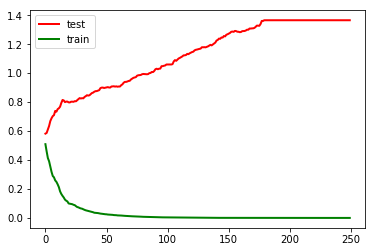

learning_rate=0.5
      Iter       Train Loss   Remaining Time 
         1           1.1255            9.56s
         2           1.0035            9.97s
         3           0.9386            9.38s
         4           0.8844            8.40s
         5           0.8381            8.02s
         6           0.7995            7.58s
         7           0.7559            7.22s
         8           0.7205            6.98s
         9           0.6958            6.67s
        10           0.6725            6.47s
        20           0.4672            5.48s
        30           0.3179            5.18s
        40           0.2274            5.02s
        50           0.1774            4.73s
        60           0.1394            4.44s
        70           0.1050            4.25s
        80           0.0805            4.03s
        90           0.0650            3.74s
       100           0.0511            3.56s
       200           0.0058            1.14s
Min log-loss: value=0.558202552316 i

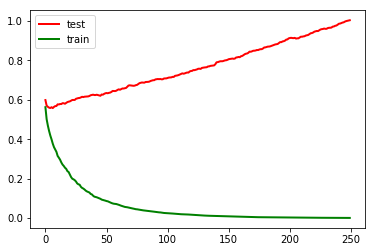

learning_rate=0.3
      Iter       Train Loss   Remaining Time 
         1           1.2095           11.47s
         2           1.1006           10.05s
         3           1.0240            9.53s
         4           0.9729            9.35s
         5           0.9387            8.53s
         6           0.8948            8.59s
         7           0.8621            8.35s
         8           0.8360            8.00s
         9           0.8171            7.66s
        10           0.7883            7.52s
        20           0.6164            6.26s
        30           0.4933            5.76s
        40           0.4248            5.11s
        50           0.3345            4.95s
        60           0.2760            4.63s
        70           0.2263            4.41s
        80           0.1971            4.08s
        90           0.1693            3.76s
       100           0.1388            3.60s
       200           0.0294            1.22s
Min log-loss: value=0.542314111002 i

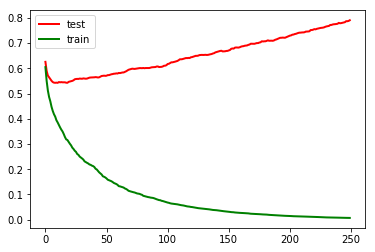

learning_rate=0.2
      Iter       Train Loss   Remaining Time 
         1           1.2613           10.54s
         2           1.1715           10.36s
         3           1.1009           10.10s
         4           1.0529            9.94s
         5           1.0130            9.79s
         6           0.9740            9.70s
         7           0.9475            9.03s
         8           0.9197            9.01s
         9           0.8979            8.50s
        10           0.8730            8.49s
        20           0.7207            6.65s
        30           0.6055            5.96s
        40           0.5244            5.43s
        50           0.4501            5.13s
        60           0.3908            4.87s
        70           0.3372            4.73s
        80           0.3009            4.47s
        90           0.2603            4.30s
       100           0.2327            3.95s
       200           0.0835            1.24s
Min log-loss: value=0.531094637597 i

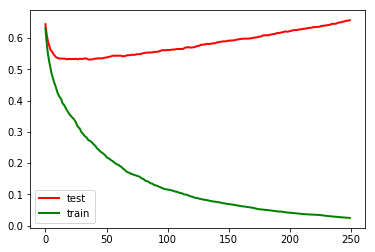

learning_rate=0.1
      Iter       Train Loss   Remaining Time 
         1           1.3199            9.73s
         2           1.2645            9.94s
         3           1.2170           10.35s
         4           1.1775           10.40s
         5           1.1404           10.48s
         6           1.1106           10.65s
         7           1.0844           10.73s
         8           1.0617           10.70s
         9           1.0411           10.63s
        10           1.0223           10.58s
        20           0.8864            9.05s
        30           0.7844            7.66s
        40           0.7176            6.76s
        50           0.6590            6.11s
        60           0.6120            5.60s
        70           0.5599            5.22s
        80           0.5242            4.76s
        90           0.4829            4.41s
       100           0.4473            4.07s
       200           0.2379            1.30s
Min log-loss: value=0.526920187228 i

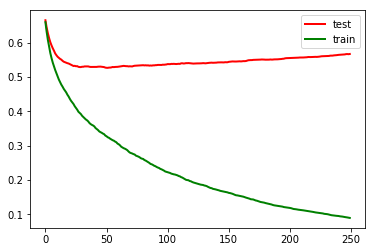

In [90]:
# Обучите GradientBoostingClassifier с параметрами n_estimators=250, verbose=True, 
# random_state=241 и для каждого значения learning_rate из списка [1, 0.5, 0.3, 0.2, 0.1] 
# проделайте следующее:
# - Используйте метод staged_decision_function для предсказания качества на обучающей 
#   и тестовой выборке на каждой итерации.
# - Преобразуйте полученное предсказание с помощью сигмоидной функции по формуле 
#     1 / (1 + e^{−y_pred}), 
#   где y_pred — предсказанное значение.
# - Вычислите и постройте график значений log-loss (которую можно посчитать с помощью функции 
#   sklearn.metrics.log_loss) на обучающей и тестовой выборках, а также найдите минимальное 
#   значение метрики и номер итерации, на которой оно достигается.
# Приведите минимальное значение log-loss на тестовой выборке и номер итерации, 
# на котором оно достигается, при learning_rate = 0.2.
def to_sigm_func(pred):
    return np.divide(1., 1 + math.e**(-pred))

for lr in [1, 0.5, 0.3, 0.2, 0.1]:
    print 'learning_rate={}'.format(lr)
    
    method = GradientBoostingClassifier(n_estimators=250, learning_rate=lr, verbose=True, 
                                        random_state=241)
    method.fit(X_train, y_train)
    
    ll_train = [log_loss(y_train, to_sigm_func(pred)) for pred in method.staged_decision_function(X_train)]
    ll_test = [log_loss(y_test, to_sigm_func(pred)) for pred in method.staged_decision_function(X_test)]
    
    mlli = np.argmin(ll_test)
    print 'Min log-loss: value={} iter={}'.format(ll_test[mlli], mlli+1)
        
    plt.figure()
    plt.plot(ll_test, 'r', linewidth=2)
    plt.plot(ll_train, 'g', linewidth=2)
    plt.legend(['test', 'train'])
    plt.show()

In [101]:
# Как можно охарактеризовать график качества на тестовой выборке, начиная с некоторой 
# итерации: переобучение (overfitting) или недообучение (underfitting)? 
# В ответе укажите одно из слов overfitting либо underfitting.
print 'overfitting'

overfitting


In [103]:
# На этих же данных обучите RandomForestClassifier с количеством деревьев, равным количеству 
# итераций, на котором достигается наилучшее качество у градиентного бустинга из предыдущего 
# пункта, c random_state=241 и остальными параметрами по умолчанию. 
# Какое значение log-loss на тесте получается у этого случайного леса? 
# (Не забывайте, что предсказания нужно получать с помощью функции predict_proba. 
# В данном случае брать сигмоиду от оценки вероятности класса не нужно)

method = RandomForestClassifier(n_estimators=37, random_state=241)
method.fit(X_train, y_train)
print log_loss(y_test, method.predict_proba(X_test))

0.540911909937


Обратите внимание, что, хотя в градиентного бустинге гораздо более слабые базовые алгоритмы, он выигрывает у случайного леса благодаря более "направленной" настройке — каждый следующий алгоритм исправляет ошибки имеющейся композиции. Также он обучается быстрее случайного леса благодаря использованию неглубоких деревьев. В то же время, случайный лес может показать более высокое качество при неограниченных ресурсах — так, он выиграет у градиентного бустинга на наших данных, если увеличить число деревьев до нескольких сотен (проверьте сами!).